In [5]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import scipy

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Read the data
vf = pd.read_csv('62.5.0-Vannføring-dogn-v1.csv', delimiter=';', on_bad_lines='skip', skiprows=[0])

# Convert comma to period in Vannføring column and convert to float
vf['Vannføring'] = vf['Vannføring'].str.replace(',', '.').astype(float)

# Split into two time periods
vf1 = vf[(vf['Tidspunkt'] >= '1991-01-01') & (vf['Tidspunkt'] <= '2020-12-31')].copy()
vf2 = vf[(vf['Tidspunkt'] >= '1961-01-01') & (vf['Tidspunkt'] <= '1990-12-31')].copy()

# Convert Tidspunkt to datetime
vf1['Tidspunkt'] = pd.to_datetime(vf1['Tidspunkt'])
vf2['Tidspunkt'] = pd.to_datetime(vf2['Tidspunkt'])

# Set Tidspunkt as index for both dataframes
vf1.set_index('Tidspunkt', inplace=True)
vf2.set_index('Tidspunkt', inplace=True)

# Sort by time
vf1.sort_index(inplace=True)
vf2.sort_index(inplace=True)

# Display the results
print("\nFirst few rows of vf1 (1991-2020):")
print(vf1.head())
print("\nFirst few rows of vf2 (1961-1990):")
print(vf2.head())


First few rows of vf1 (1991-2020):
                           Vannføring  Korrigert  Kontrollert
Tidspunkt                                                    
1991-01-01 11:00:00+00:00    27.90077          0            3
1991-01-02 11:00:00+00:00    24.30701          0            3
1991-01-03 11:00:00+00:00    23.61584          0            3
1991-01-04 11:00:00+00:00    22.93392          0            3
1991-01-05 11:00:00+00:00    22.26125          0            3

First few rows of vf2 (1961-1990):
                           Vannføring  Korrigert  Kontrollert
Tidspunkt                                                    
1961-01-01 11:00:00+00:00    8.919145          0            3
1961-01-02 11:00:00+00:00    8.681128          0            3
1961-01-03 11:00:00+00:00    9.161231          0            3
1961-01-04 11:00:00+00:00    8.681128          0            3
1961-01-05 11:00:00+00:00    7.551074          0            3


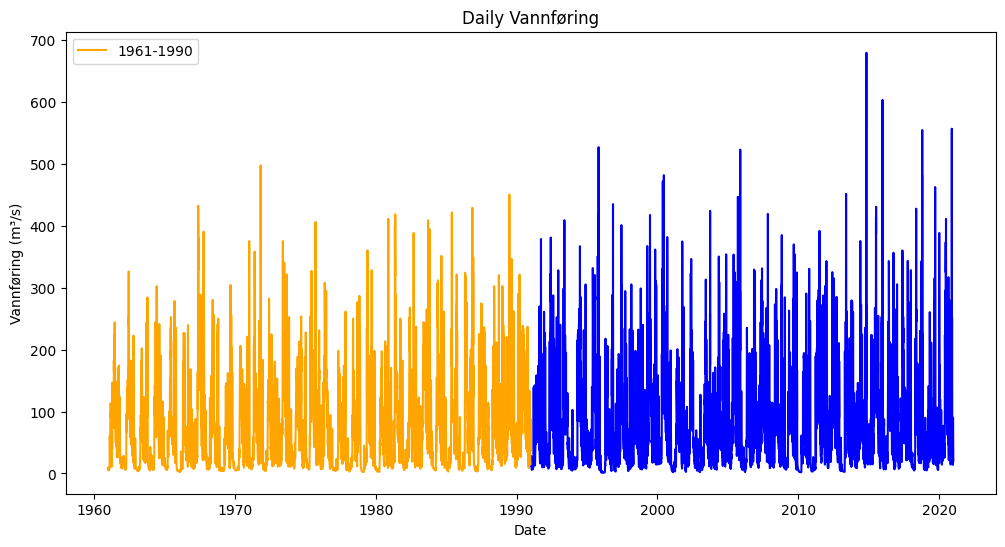

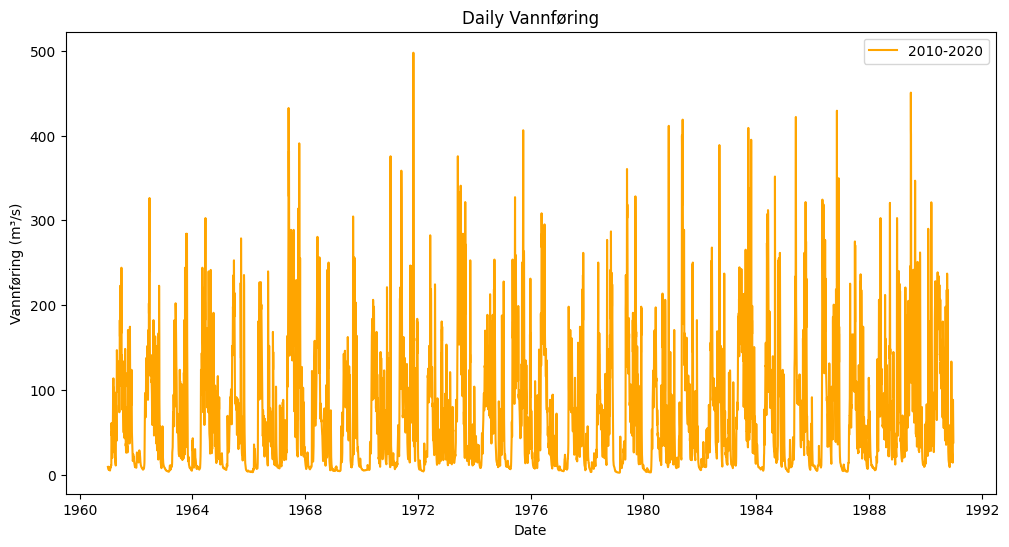

In [25]:
#Plotting
plt.figure(figsize=(12,6))
plt.plot(vf1['Vannføring'], color='blue')
plt.plot(vf2['Vannføring'], label='1961-1990', color='orange')
plt.xlabel('Date')
plt.ylabel('Vannføring (m³/s)')
plt.title('Daily Vannføring')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
#plt.plot(vf1['Vannføring'], color='blue')
plt.plot(vf2['Vannføring'], label='2010-2020', color='orange')
plt.xlabel('Date')
plt.ylabel('Vannføring (m³/s)')
plt.title('Daily Vannføring')
plt.legend()
plt.show()

In [26]:
#Import flomverdier
flomverdier = pd.read_csv('flomverdier.csv', delimiter=';', on_bad_lines='skip', skiprows=[0])

FileNotFoundError: [Errno 2] No such file or directory: 'flomverdier.csv'